In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

In [ ]:
anchor_images_path = "/content/drive/MyDrive/Sorted_logo_3"
positive_images_path = "/content/drive/MyDrive/Augmented_logo"

In [ ]:
anchor_images = sorted([os.path.join(anchor_images_path, f) for f in os.listdir(anchor_images_path)])
positive_images = sorted([os.path.join(positive_images_path, f) for f in os.listdir(positive_images_path)])

In [ ]:
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

In [ ]:
# Получение списка пар акорных и позитивных изображений
#pairs = [(anchor_images_path + "/" + a + ".jpg", positive_images_path + "/" + p + ".jpg")
         #for a, p in zip(anchor_ids, positive_ids) if a == p]

In [ ]:
# Создание Dataset из пар акорных и позитивных изображений
#dataset = tf.data.Dataset.from_tensor_slices(pairs)

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [ ]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [ ]:
image_count = len(anchor_images)
train_count = round(image_count * 0.7)
val_count = round(image_count * 0.2)
test_count = image_count - train_count - val_count

train_dataset = dataset.take(train_count)
val_dataset = dataset.skip(train_count).take(val_count)
test_dataset = dataset.skip(train_count + val_count)


In [ ]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

In [ ]:
val_dataset = val_dataset.batch(16, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
test_dataset = test_dataset.batch(4, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)

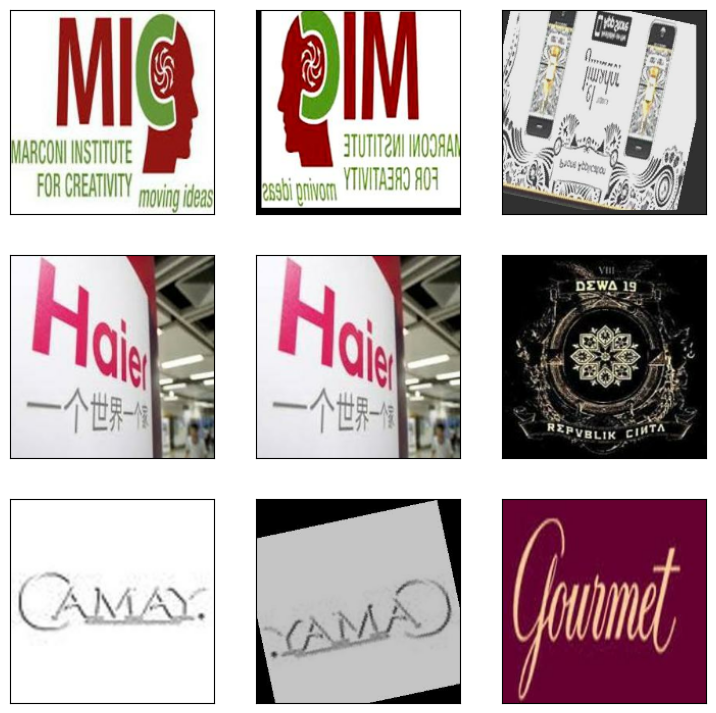

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)
embedding = Model(base_cnn.input, output, name="Embedding")
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    def get_config(self):
        return super().get_config()

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    def build(self, input_shape):
        super().build(input_shape)
        self.siamese_network.build(input_shape)
    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def get_config(self):
        config = {"siamese_network": tf.keras.models.save_model(self.siamese_network),
                  "margin": self.margin}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

In [ ]:
@property
def metrics(self):
    # We need to list our metrics here so the `reset_states()` can be
    # called automatically.
    return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=0, validation_data=val_dataset)

In [ ]:
tf.saved_model.save(siamese_model, '/content/drive/MyDrive/siamese_model')

In [ ]:
batch_size = 12

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Загрузка модели
model = tf.saved_model.load('/content/drive/MyDrive/siamese_model')

# Загрузка тестового набора данных
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Вычисление расстояний между изображениями в каждой тройке
def predict_distance(model, anchor, positive, negative):
    anchor_feature = model.predict(anchor)
    positive_feature = model.predict(positive)
    negative_feature = model.predict(negative)
    pos_distance = tf.reduce_sum(tf.square(anchor_feature - positive_feature), axis=1)
    neg_distance = tf.reduce_sum(tf.square(anchor_feature - negative_feature), axis=1)
    return pos_distance, neg_distance

# Прогнозирование меток классов на основе расстояний
def predict_label(pos_distance, neg_distance, threshold):
    pos_label = (pos_distance < threshold)
    neg_label = (neg_distance < threshold)
    return tf.logical_and(pos_label, tf.logical_not(neg_label))

# Оценка качества модели на тестовом наборе данных
def evaluate(model, test_dataset, threshold):
    y_true = []
    y_pred = []
    for anchor, positive, negative in test_dataset:
        pos_distance, neg_distance = predict_distance(model, anchor, positive, negative)
        label = predict_label(pos_distance, neg_distance, threshold)
        y_true.extend([True] * len(anchor))
        y_pred.extend(label.numpy().tolist())
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return conf_mat, accuracy, precision, recall, f1, roc_auc

# Вызов функции evaluate() для вычисления метрик качества на тестовом наборе данных
conf_mat, accuracy, precision, recall, f1, roc_auc = evaluate(model, test_dataset, threshold=0.5)

# Вывод результатов
print('Confusion matrix:\n', conf_mat)
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1))
print('AUC-ROC: {:.4f}'.format(roc_auc))

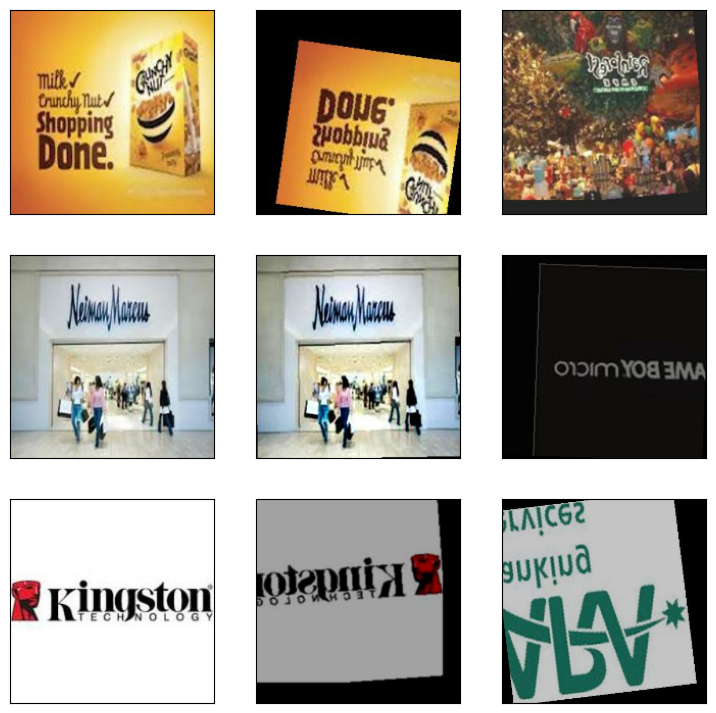

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = tf.keras.losses.cosine_similarity

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: [-0.99856603 -0.99963284 -0.98965204 -0.9989882  -0.99363035 -0.99705535
 -0.997643   -0.9974662  -0.99287856 -0.9965341  -0.9976108  -0.9996411
 -0.99237955 -0.9977304  -0.9976909  -0.99926066 -0.99949944 -0.99985075
 -0.9877304  -0.9999696  -0.9951406  -0.9984405  -0.9987967  -0.9999529
 -0.99093056 -0.99803936 -0.99805343 -0.9973965  -0.9993843  -0.9959451
 -0.9980219  -0.99931264]
Negative similarity [-0.99780947 -0.99651116 -0.97270846 -0.98803055 -0.9876101  -0.9960598
 -0.98712057 -0.9916333  -0.9931066  -0.9919176  -0.9952426  -0.9879166
 -0.97720563 -0.99505043 -0.9882178  -0.9971544  -0.98966444 -0.9974564
 -0.9670731  -0.9764031  -0.9813132  -0.99759656 -0.99213195 -0.9909104
 -0.9877083  -0.9936714  -0.99682736 -0.99067795 -0.9896949  -0.990893
 -0.995847   -0.99801767]
